# Pregunta 2

### a) En primer lugar se crea el dataframe y se analizan sus registros.

In [1]:
import urllib
import pandas as pd
train_data_url = "http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.train"
test_data_url = "http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.dev"
train_data_f = urllib.urlretrieve(train_data_url, "train_data.csv")
test_data_f = urllib.urlretrieve(test_data_url, "test_data.csv")
ftr = open("train_data.csv", "r")
fts = open("test_data.csv", "r")
rows = [line.split(" ",1) for line in ftr.readlines()]
train_df = pd.DataFrame(rows, columns=['Sentiment','Text'])
train_df['Sentiment'] = pd.to_numeric(train_df['Sentiment'])
rows = [line.split(" ",1) for line in fts.readlines()]
test_df = pd.DataFrame(rows, columns=['Sentiment','Text'])
test_df['Sentiment'] = pd.to_numeric(test_df['Sentiment'])
print "Dimensiones training set: ", train_df.shape
print "Dimensiones testing set: ", test_df.shape
print "----------------------------------------------------------"
print  "Conteo de registros de cada clase en el training set"
print train_df['Sentiment'].value_counts()
print "----------------------------------------------------------"
print  "Conteo de registros de cada clase en el testing set"
print test_df['Sentiment'].value_counts()
#print train_df.head()
#print test_df.tail()

Dimensiones training set:  (3554, 2)
Dimensiones testing set:  (3554, 2)
----------------------------------------------------------
Conteo de registros de cada clase en el training set
-1    1784
 1    1770
Name: Sentiment, dtype: int64
----------------------------------------------------------
Conteo de registros de cada clase en el testing set
-1    1803
 1    1751
Name: Sentiment, dtype: int64


### b) En esta sección se pre procesa el texto mediante la utilización de las operaciones lower-casing, y stemming. Para ello se crea la función word_extractor.

In [2]:
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer
def word_extractor(text,stop = 1):
    #wordlemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    '''wordtokens = [ wordlemmatizer.lemmatize(word.lower()) \
                  for word in word_tokenize(text.decode('utf-8', 'ignore')) ]'''
    wordtokens = [ stemmer.stem(word.lower()) \
                  for word in word_tokenize(text.decode('utf-8', 'ignore')) ]
    for word in wordtokens:
        if stop==1:
            if word not in commonwords:
                words+=" "+word
        else:
            words+=" "+word
    return words
print word_extractor("I love to eat cake")
print word_extractor("I love eating cake")
print word_extractor("I loved eating the cake")
print word_extractor("I do not love eating cake")
print word_extractor("I dont love eating cake")
print word_extractor("I like learning in  university")
print word_extractor("The cats are playing with fishes")
print word_extractor("He believes in miracles")

 love eat cake
 love eat cake
 love eat cake
 love eat cake
 dont love eat cake
 like learn univers
 cat play fish
 believ miracl


En el caso anterior, el stemming lleva todas las palabras a su raíz sin importar el contexto en donde estas se encuentren. Stemming no puede discriminar, y solo se basa en ver las conjugaciones de las palabras de forma heurísticas, y dependiendo de la terminación es como decide a que raíz pertenece. Esto puede ocasionar problemas como por ejemplo con la palabra university, en donde el proceso de stemming la transforma a univers y puede ocasionar perdida de informacion ya que cambia el significado.

Si no se realiza stemming, las palabras quedarían conjugadas y para un procesador de texto o clasificador, no serían equivalentes aunque estén en un contexto similar. El problema es entonces que se generarían mas palabras, con lo cual aumenta el vocabulario y por ende la complejidad del dataset.

Con respecto a los "stop words", estos se definen en un conjunto de articulos, pronombres y preposiciones, y son quitados de las cadenas de texto, ya que son palabras muy comunes y que no aportan significado al texto, aunque en algunas aplicaciones si pueden llegar a ser utilizadas.

### c) En este caso se utiliza un lemmatizer para comparar con los resultados anteriores.

In [3]:
def word_extractor2(text, stop=1):
    wordlemmatizer = WordNetLemmatizer()
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ wordlemmatizer.lemmatize(word.lower()) \
                  for word in word_tokenize(text.decode('utf-8','ignore')) ]
    for word in wordtokens:
        if stop==1:
            if word not in commonwords:
                words+=" "+word
        else:
            words+=" "+word
    return words

print word_extractor2("I love to eat cake")
print word_extractor2("I love eating cake")
print word_extractor2("I loved eating the cake")
print word_extractor2("I do not love eating cake")
print word_extractor2("I dont love eating cake")
print word_extractor2("I like learning in  university")
print word_extractor2("The cats are playing with fishes")
print word_extractor2("He believes in miracles")

 love eat cake
 love eating cake
 loved eating cake
 love eating cake
 dont love eating cake
 like learning university
 cat playing fish
 belief miracle


Procesando las cadenas mediante el lemmatizer, se conserva muchas veces la conjugación de las palabras según el contexto, y también son llevadas a su tronco léxico. Por ejemplo las palabras loved y eating se conservan, y en este caso university se mantiene igualmente, no así en el proceso de stemming. Entonces la lematización es un proceso mucho más complejo, que no solo revisa cada palabra y su terminación, sino que además observa el contexto para realizar la agrupación de palabras similares.

### d) Top 10 palabras más frecuentes

In [4]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
# Se crean las listas con los textos procesados
texts_train = [word_extractor2(text) for text in train_df.Text]
texts_test = [word_extractor2(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train))
#Se crea la matriz con la cuenta de los tokens(test y train)
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)
print "Dimension conjunto de entrenamiento: ",features_train.shape
print "Dimension conjunto de pruebas: ", features_test.shape
print "--------------------------------------------------------------"
#label 0 y 1
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()
dist_tr=list(np.array(features_train.sum(axis=0)).reshape(-1,))
dist_ts=list(np.array(features_test.sum(axis=0)).reshape(-1,))
#for tag, count in zip(vocab, dist):
#    print count, tag
index_tr= sorted(range(len(dist_tr)), key=lambda k: dist_tr[k], reverse=True )
index_ts= sorted(range(len(dist_ts)), key=lambda k: dist_ts[k], reverse=True )
#print sorted(dist_tr, reverse=True)[0]
print "10 Palabras mas frecuentes \n"
print "{0:<30}{1} \n".format("Conjunto de entrenamiento","Conjunto de pruebas")
for i in range (0,10):
    m1=index_tr[i]
    m2=index_ts[i]
    print '{0:<5}{1:<25}{2:<5}{3}'.format(dist_tr[m1], vocab[m1], dist_ts[m2], vocab[m2])

Dimension conjunto de entrenamiento:  (3554, 9663)
Dimension conjunto de pruebas:  (3554, 9663)
--------------------------------------------------------------
10 Palabras mas frecuentes 

Conjunto de entrenamiento     Conjunto de pruebas 

566  film                     558  film
481  movie                    540  movie
246  one                      250  one
245  like                     238  ha
224  ha                       230  like
183  make                     197  story
176  story                    175  character
163  character                165  time
145  comedy                   161  make
143  even                     134  comedy


Se aprecia en la tabla anterior, que el vocabulario se compone de 9663 palabras o tokens,  y que tanto los set de entrenamiento y prueba contienen 3554 registros o "reviews" de usuarios. Las 10 palabras más frecuentes se repiten en gran medida en ambos conjuntos y conservan un orden similar, esto refleja que los datos presentan estructuras similares.

### e) Función para evaluar el desemepeño de un clasificador

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
def score_the_model(model,x,y,xt,yt,text):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    print "Training Accuracy %s: %f"%(text,acc_tr)
    print "Test Accuracy %s: %f"%(text,acc_test)
    print "Detailed Analysis Testing Results ..."
    print(classification_report(yt, model.predict(xt), target_names=['+','-']))
    precision, recall, fscore, support = precision_recall_fscore_support(yt, model.predict(xt))
    
    if text == 'BernoulliNB':
        metricas_bernoulliNB.append((acc_tr, acc_test, np.mean(precision), np.mean(recall), np.mean(fscore)))
    elif text == 'MultinomialNB':
        metricas_multinomial.append((acc_tr, acc_test, np.mean(precision), np.mean(recall), np.mean(fscore)))
    elif text == 'LOGISTIC':
        metricas_logit.append((acc_tr, acc_test, np.mean(precision), np.mean(recall), np.mean(fscore)))
    elif text == 'SVM':
        metricas_svm.append((acc_tr, acc_test, np.mean(precision), np.mean(recall), np.mean(fscore)))

La función $\textit{classification_report}$  imprime 3 métricas las cuales son precision, recall y F1 score.
$\textit{Precision}$ se define como:

$$ precision = \frac{tp}{tp+fp}$$ 

Donde tp representa los verdaderos positivos y fp los falsos positivos. Intuitivamente es la habilidad del clasificador para no etiquetar como positivo una muestra que es negativa. Su mejor valor es 1 y su peor valor es 0.

Recall score se define como: 

$$ recall = \frac{tp}{tp+fn}$$ 

Donde tp representa los verdaderos positivos y fn los falsos negativos. Recall representa la habilidad del clasificador para encontrar todos los ejemplos positivos. Su mejor valor es 1 y su peor valor es 0.

Entonces $\textit{precision}$ representa la exactitud o calidad del clasificador y $\textit{recall}$ la medida de completitud o cantidad.

Finalmente, F1 es una medida que utiliza las dos métricas anteriores en un promedio ponderado. Su fórmula es: 

$$ f1 = 2* \frac{precision * recall}{precision+recall}$$


## f) Bernoulli Naive Bayes

El siguiente código crea los textos y features sin stop words y además otro utilizando stemming, para posteriormente ser analizados.

In [6]:
# El caso comun en el puntop (d) es lemmatizer filtrando stopwords
# Se crea training y testing set sin filtrar stopwords mediante lemmatizer.

texts_train_SW = [word_extractor2(text, 0) for text in train_df.Text]
texts_test_SW = [word_extractor2(text,0) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train_SW))
#Se crea la matriz con la cuenta de los tokens(test y train)
features_train_SW = vectorizer.transform(texts_train_SW)
features_test_SW = vectorizer.transform(texts_test_SW)

# Se crea training y testing set utilizando stemming

texts_train_stem = [word_extractor(text) for text in train_df.Text]
texts_test_stem = [word_extractor(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train_stem))
#Se crea la matriz con la cuenta de los tokens(test y train)
features_train_stem = vectorizer.transform(texts_train_stem)
#print features_train_stem.shape
features_test_stem = vectorizer.transform(texts_test_stem)

# Training y testing set utilizando stemming sin filtrar stop words
texts_train_stemSW = [word_extractor(text,0) for text in train_df.Text]
texts_test_stemSW = [word_extractor(text,0) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train_stemSW))
#Se crea la matriz con la cuenta de los tokens(test y train)
features_train_stemSW = vectorizer.transform(texts_train_stemSW)
#print features_train_stem.shape
features_test_stemSW = vectorizer.transform(texts_test_stemSW)


##### Modelo con lemmatizer y filtrando stop words Bernoulli NB

Para el caso de Bernoulli naive bayes los features deben tener valor 0 o 1, esto lo hace automáticamente BernoulliNB de la librería sklearn.

In [7]:
from sklearn.naive_bayes import BernoulliNB
import random
metricas_bernoulliNB = []
def do_NAIVE_BAYES(x,y,xt,yt):
    model = BernoulliNB()
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"BernoulliNB")
    return model
model=do_NAIVE_BAYES(features_train,labels_train,features_test,labels_test)

Training Accuracy BernoulliNB: 0.958638
Test Accuracy BernoulliNB: 0.738531
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.73      0.74      1803
          -       0.73      0.75      0.74      1751

avg / total       0.74      0.74      0.74      3554



La tabla anterior muestra que el desempeño de Bernoulli Naive Bayes no es del todo bueno, ya que presenta una alta exactitud en el set de entrenamiento, pero mucho peor en el de pruebas, dando entender que el modelo esta sobre ajustando los datos. Esto también queda en evidencia con los otros indicadores como precision y recall, de donde la calidad para clasificar no es muy alta, y tampoco es completa. Esto puede deberse principalmente a que no se toma en cuenta la cantidad de palabras o tokens en cada registro, sino que son transformados a 0 o 1, perdiendo así información.

##### Modelo con lemmatizer sin filtrar stop words Bernoulli NB

In [8]:
model_SW=do_NAIVE_BAYES(features_train_SW,labels_train,features_test_SW,labels_test)

Training Accuracy BernoulliNB: 0.955262
Test Accuracy BernoulliNB: 0.748663
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.76      0.74      0.75      1803
          -       0.74      0.76      0.75      1751

avg / total       0.75      0.75      0.75      3554



Aquí no se presenta gran mejora, el modelo sigue sobre ajustando, pero al no considerarse el número de veces que aparece un stop word en un texto, sino que solo se interpreta como si está o no, esto no afecta demasiado a los resultados. Una ventaja es que requiere menos pre procesamiento, sin embargo al tener mas tokens, aumenta el procesamiento de cómputo del modelo.

##### Modelo con stemmer Bernoulli NB

In [9]:
model_stem = do_NAIVE_BAYES(features_train_stem,labels_train,features_test_stem,labels_test)

Training Accuracy BernoulliNB: 0.942881
Test Accuracy BernoulliNB: 0.747819
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.76      0.74      0.75      1803
          -       0.74      0.75      0.75      1751

avg / total       0.75      0.75      0.75      3554



Al igual que el caso anterior, la mejora es muy pequeña, sin embargo al usar stemming el procesamiento de los datos es más rápido ya que no debe interpretar el contexto y además genera muchos menos features que lemmatization, 1700 palabras menos en el vocabulario aproximadamente. Esto muestra que bernoulli no se ve afectado por la cantidad de features en gran medida. Por lo mismo se concluye que stemming resulta ser mejor técnica de pre procesamiento que lemmatization en este caso.

##### Modelo con stemmer sin filtrar stop words Bernoulli NB

In [10]:
model_stemSW = do_NAIVE_BAYES(features_train_stemSW,labels_train,features_test_stemSW,labels_test)

Training Accuracy BernoulliNB: 0.938098
Test Accuracy BernoulliNB: 0.762173
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.77      0.76      0.77      1803
          -       0.76      0.76      0.76      1751

avg / total       0.76      0.76      0.76      3554



Este es el mejor caso de todos, corresponde a utilizar stemming y utilizar stop words. Este resultado intuitivamente parece incorrecto, ya que stemming pierde información, pero resulta ser que stemming en general presenta mejor desempeño que lemmatization. Por otra parte, al no filtrar los stop words, en textos relativamente pequeños, se presentan mejores resultados, esto posiblemente es porque al ser tan pocos conectores, pronombres, etc. en un texto pequeño, la información que adicionan al contexto del mensaje es beneficioso. No ocurre lo mismo en documentos muy grandes, en donde estos stop words comunes se suelen repetir cientos de veces.

##### Análisis exploratorio Bernoulli NB

Notar que en la impresión de la probabilidad por clase, la primera es la clase 0 o comentario negativo y la siguiente es la clase 1 o positivo.

In [11]:
test_pred = model.predict_proba(features_test)
#predictions = model.predict(features_test)
#print model.classes_
spl = random.sample(xrange(len(test_pred)), 5)
for text, sentiment, lab in zip(test_df.Text[spl], test_pred[spl], labels_test[spl]):
    print sentiment, text, "Valor real: ", lab, "\n"

[ 0.99469262  0.00530738] with little visible talent and no energy , colin hanks is in bad need of major acting lessons and maybe a little coffee .
Valor real:  0.0 

[ 0.99617713  0.00382287] too bad writer-director adam rifkin situates it all in a plot as musty as one of the golden eagle's carpets .
Valor real:  0.0 

[ 0.21984964  0.78015036] one of those terrific documentaries that collect a bunch of people who are enthusiastic about something and then figures out how to make us share their enthusiasm .
Valor real:  1.0 

[ 0.88166857  0.11833143] every so often a movie comes along that confirms one's worse fears about civilization as we know it . the new guy is one of them .
Valor real:  0.0 

[ 0.88050228  0.11949772] snipes is both a snore and utter tripe .
Valor real:  0.0 



Según lo apreciado, hay ciertas palabras que inmediatamente se categorizan como "negativas", por ejemplo las palabra worst o bad, o también existen algunas palabras que aumentan la probabilidad de ser clasificadas como positivos significativamente, como por ejemplo exciting. Esto se debe a que en muchas reseñas aparecen este tipo de palabras que demuestran expresión ya sea positiva o negativa.

Un problema que se presenta es cuando el clasificador no es capaz de reconocer la completitud del mensaje, por ejemplo este: "i simply can't recommend it enough .", le asigna 90% a que es negativo cuando realmente es positivo, entonces esto ocurre al no considerar el contexto entero del review, ya que Bernoulli se basa en la independencia condicional de las características.

## g) Multinomial Naive Bayes

##### Modelo con lemmatizer y filtrando stop words Multinomial NB

In [12]:
from sklearn.naive_bayes import MultinomialNB
import random
metricas_multinomial = []
def do_MULTINOMIAL(x,y,xt,yt):
    model = MultinomialNB()
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"MultinomialNB")
    return model
model=do_MULTINOMIAL(features_train,labels_train,features_test,labels_test)

Training Accuracy MultinomialNB: 0.959482
Test Accuracy MultinomialNB: 0.740782
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.73      0.74      1803
          -       0.73      0.75      0.74      1751

avg / total       0.74      0.74      0.74      3554



El modelo no es demasiado preciso, como ocurre con Bernoulli Naive Bayes, de hecho la accuracy obtenida en el set de pruebas es levemente superior a Bernoulli. Las métricas prácticamente son las mismas que Bernoulli NB, mostrando así que no existe mejoría entre una técnica u otra. Esto puede deberse en primera instancia a que los textos no presentan muchas palabras repetidas, luego la gran mayoría de los reviews tienen features binarios, con lo cual es similar a la distribución Binomial que consiste en "n" ensayos Bernoulli.

##### Modelo con lemmatizer sin filtrar stop words Multinomial NB

In [13]:
model_SW=do_MULTINOMIAL(features_train_SW,labels_train,features_test_SW,labels_test)

Training Accuracy MultinomialNB: 0.955543
Test Accuracy MultinomialNB: 0.747537
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.75      0.75      1803
          -       0.74      0.74      0.74      1751

avg / total       0.75      0.75      0.75      3554



Nuevamente, al no filtrar stop words se presenta un mejor resultado en la clasificación. Esto resulta ser raro, debido a que se esperaría que al eliminar la información no relevante el clasificador se comportara de mejor forma aumentando su desempeño. Por lo mismo se utiliza el mismo argumento que en Bernoulli NB, donde se asume que la longitud de los textos tienen pocas stop words y que estas ayudan a clasificar.

##### Modelo con stemmer Multinomial NB

In [14]:
model_stem = do_MULTINOMIAL(features_train_stem,labels_train,features_test_stem,labels_test)

Training Accuracy MultinomialNB: 0.942319
Test Accuracy MultinomialNB: 0.749789
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.76      0.75      0.75      1803
          -       0.74      0.75      0.75      1751

avg / total       0.75      0.75      0.75      3554



Utilizar un stemmer en Multinomial Naive Bayes resulta ser más beneficioso que un lemmatizer, ya que la accuracy sobre el set de pruebas aumenta. La precisión es mejor, al igual que el recall y el f1 score. Al parecer todo el análisis anterior indica que multinomial tiene el mismo comportamiento que bernoulli, es decir, es mejor utilizar stemming.

##### Modelo con stemmer sin filtrar stop words Multinomial NB

In [15]:
model_stemSW = do_MULTINOMIAL(features_train_stemSW,labels_train,features_test_stemSW,labels_test)

Training Accuracy MultinomialNB: 0.940630
Test Accuracy MultinomialNB: 0.759921
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.76      0.77      0.76      1803
          -       0.76      0.75      0.76      1751

avg / total       0.76      0.76      0.76      3554



Stemming sin filtro de stop words obtiene los mejores resultados para Multinomial NB, estableciendo así que stemming es mejor técnica de pre procesamiento de textos en este caso, y además al eliminar tokens no relevantes, requiere menor cantidad de recursos para procesar el modelo.

##### Analisis exploratorio Multinomial NB

In [16]:
test_pred = model.predict_proba(features_test)
#predictions = model.predict(features_test)
#print model.classes_
spl = random.sample(xrange(len(test_pred)), 5)
for text, sentiment, lab in zip(test_df.Text[spl], test_pred[spl], labels_test[spl]):
    print sentiment, text, "Valor real: ", lab, "\n"

[ 0.19177236  0.80822764] on the right track to something that's creepy and effective . . . it's just going to take more than a man in a bullwinkle costume to get there .
Valor real:  0.0 

[ 0.11752359  0.88247641] a taut , intelligent psychological drama .
Valor real:  1.0 

[ 0.94967351  0.05032649] the only element of suspense is whether the movie will change titles or distributors again before the closing credits roll .
Valor real:  0.0 

[ 0.23686327  0.76313673] those who aren't put off by the film's austerity will find it more than capable of rewarding them .
Valor real:  1.0 

[ 0.99515935  0.00484065] this dramatically shaky contest of wills only reiterates the old hollywood saw : evil is interesting and good is boring .
Valor real:  0.0 



Al igual que en Bernoulli Naive Bayes, se presentan el mismo tipo de errores de clasificación, aunque en este caso la repetición de una palabra afecta mucho mas a las probabilidades que el clasificador asigna a cada clase. Al ser las palabras condicionalmente independientes a cada clase, es irrelevante la distribución entre ellas, es por esto que si una palabra esta en muchos textos clasificados de cierta forma, inmediatamente afecta la probabilidad de clasificación de esa clase, independiente de las demás palabras del mensaje. Por esto se considera ingenuo, pero aun así obtiene resultados admisibles.

## h) Regresión Logística regularizado.

A continuación se presenta la función que realiza la regresión logística regularizada, en donde se utilizan diversos parámetros de regularización. Notar que el parámetro "C" corresponde al inverso de la regularización, vale decir, mientras menor es su valor, mayor será la penalización. El significado de este parámetro, como ocurre en regresión lineal, es principalmente determinar que features, o tokens en este caso presentan mayor o menor significancia al modelo afectando directamente a los coeficientes de la regresión. Si no se aplica regularización, en modelos donde existen muchos features es probable que ocurra overfitting, ya que se necesitaría muchos datos de entrenamiento para que no ocurra esa situación.

El efecto esperado del parámetro "C" de la regresión, es que al disminuirlo, se espera mayor penalización, provocando menos overfitting, es decir generalizando en mayor medida ya que el modelo se ajusta a las variables que si son importantes, y así el problema no se vuelve demasiado especifico. Esto debe realizarse en clasificación de texto debido a que el vocabulario puede abarcar miles de palabras.

In [17]:
from sklearn.linear_model import LogisticRegression

#Función creada para determinar el mejor parametro de regularización en los clasificadores que lo necesiten
def score_the_model2(model,x,y,xt,yt,text):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    return acc_test

metricas_logit = []
def do_LOGIT(x,y,xt,yt, C):
    if C == 0:
        Cs = np.logspace(3,-2,base=10) #[0.01,0.1,10,100,1000]
        best_c = 0
        acc_test = []
        for C in Cs:
            #print "Usando C= %f"%C
            model = LogisticRegression(penalty='l2',C=C)
            model = model.fit(x, y)
            acc_test.append(score_the_model2(model,x,y,xt,yt,"LOGISTIC"))

        best_c = Cs[acc_test.index(max(acc_test))]
        return best_c
    else:
        model = LogisticRegression(penalty='l2',C=C)
        model = model.fit(x, y)
        score_the_model(model,x,y,xt,yt,"LOGISTIC")
        return model

##### Modelo con lemmatizer y filtrando stop words Regresión Logística

In [18]:
C = do_LOGIT(features_train, labels_train, features_test, labels_test, 0)
print "Mejor parámetro de regularización es %f"% C
print "\nMétricas Lematizador con C = %f"% C
model = do_LOGIT(features_train, labels_train, features_test, labels_test, C)

Mejor parámetro de regularización es 0.268270

Métricas Lematizador con C = 0.268270
Training Accuracy LOGISTIC: 0.944007
Test Accuracy LOGISTIC: 0.726991
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.73      0.73      1803
          -       0.72      0.72      0.72      1751

avg / total       0.73      0.73      0.73      3554



##### Modelo con lemmatizer sin filtrar stop words Regresión Logística

In [19]:
C = do_LOGIT(features_train_SW, labels_train, features_test_SW, labels_test, 0)
print "Mejor parámetro de regularización es %f"% C
print "\nMétricas Lematizador sin Stopwords con C = %f"% C
model_SW = do_LOGIT(features_train_SW, labels_train, features_test_SW, labels_test, C)

Mejor parámetro de regularización es 2.811769

Métricas Lematizador sin Stopwords con C = 2.811769
Training Accuracy LOGISTIC: 0.998312
Test Accuracy LOGISTIC: 0.737405
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.73      0.74      1803
          -       0.73      0.75      0.74      1751

avg / total       0.74      0.74      0.74      3554



##### Modelo con stemmer Regresión Logística

In [20]:
C = do_LOGIT(features_train_stem, labels_train, features_test_stem, labels_test, 0)
print "Mejor parámetro de regularización es %f"% C
print "\nMétricas Stemming con C = %f"% C
model_stem = do_LOGIT(features_train_stem, labels_train, features_test_stem, labels_test, C)

Mejor parámetro de regularización es 0.868511

Métricas Stemming con C = 0.868511
Training Accuracy LOGISTIC: 0.978616
Test Accuracy LOGISTIC: 0.738249
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.74      0.74      0.74      1803
          -       0.74      0.73      0.73      1751

avg / total       0.74      0.74      0.74      3554



##### Modelo con stemmer sin filtrar stop words Regresión Logística

In [21]:
C = do_LOGIT(features_train_stemSW, labels_train, features_test_stemSW, labels_test, 0)
print "Mejor parámetro de regularización es %f"% C
print "\nMétricas Stemming con C = %f"% C
model_stemSW = do_LOGIT(features_train_stemSW, labels_train, features_test_stemSW, labels_test, C)

Mejor parámetro de regularización es 1.389495

Métricas Stemming con C = 1.389495
Training Accuracy LOGISTIC: 0.989308
Test Accuracy LOGISTIC: 0.747256
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.75      0.75      1803
          -       0.74      0.75      0.74      1751

avg / total       0.75      0.75      0.75      3554



En primer lugar, los resultados mostrados para cada modelo se obtienen con el mejor parámetro de regularización $C$ encontrado para cada uno, utilizando como medida la exactitud (Accuracy) de prueba.

En general, se vuelve a repetir la tendencia ya establecida en los dos modelos de clasificación anteriores, es decir, stemming logra un mejor desempeño. Además, al quitar el filtrado de stop words tanto el modelo utilizando stemming como lemmatizer mejoran sus resultados. Nuevamente, esto se debe a que en general los comentarios de personas no son muy extensos, entonces al aplicar el filtrado de palabras comunes (stop words) reduce significativamente el tamaño de los comentarios, ocurriendo perdida de información que puede ser relevante para que el modelo logre una mejor clasificación, cómo por ejemplo identificar mejor el contexto de una frase para determinar si es una ironía. No obstante, al no pre procesar los stop words el modelo se vuelve más complejo, ya que el vocabulario aumenta significativamente, y además se pierde cierto poder de análisis en el conjunto de datos ya que las palabras más comunes son en su mayoría artículos, pronombres y preposiciones.

##### Analisis exploratorio Regresión Logística

In [22]:
test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 5)
for text, sentiment, lab in zip(test_df.Text[spl], test_pred[spl], labels_test[spl]):
    print sentiment, text, "Valor real: ", lab, "\n"

[ 0.87890293  0.12109707] the movie does such an excellent job of critiquing itself at every faltering half-step of its development that criticizing feels more like commiserating .
Valor real:  0.0 

[ 0.26298563  0.73701437] this ready-made midnight movie probably won't stand the cold light of day , but under the right conditions , it's goofy ( if not entirely wholesome ) fun .
Valor real:  1.0 

[ 0.31760528  0.68239472] it's as raw and action-packed an experience as a ringside seat at a tough-man contest .
Valor real:  1.0 

[ 0.39556957  0.60443043] wouldn't it be funny if a bunch of allied soldiers went undercover as women in a german factory during world war ii ? um , no . but here's a movie about it anyway .
Valor real:  0.0 

[ 0.70615915  0.29384085] watching this film , what we feel isn't mainly suspense or excitement . the dominant feeling is something like nostalgia .
Valor real:  1.0 



### i) Máquina de Vectores de Soporte (SVM) Lineal

Al igual que en Regresión logística, SVM es regularizado mediante $C$ que es el inverso del parámetro de regularización conocido en Regresión lineal. Por lo que el efecto esperado para valores pequeño de $C$ es una reducción del overfitting, debido a que existe una mayor penalización. Por consiguiente para valores grandes de $C$ se espera que exista un mayor overfitting debido a que disminuye la penalización. 

Además, el kernel utilizado en la SVM es lineal. También fue necesario incorporar *CalibratedClassifierCV* de *sklearn.calibration*, el cual permite agregar una salida de probabilidad a SVM Lineal.

In [23]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
metricas_svm = []
def do_SVM(x,y,xt,yt,C):
    if C == 0:
        best_c = 0
        acc_test = []
        Cs = [0.01,0.1,10,100,1000]
        for C in Cs:
            #print "El valor de C que se esta probando: %f"%C
            model = LinearSVC(C=C)
            model = CalibratedClassifierCV(model) 
            model = model.fit(x, y)
            acc_test.append(score_the_model2(model,x,y,xt,yt,"SVM"))

        best_c = Cs[acc_test.index(max(acc_test))]
        return best_c
    else:
        model = LinearSVC(C=C)
        model = CalibratedClassifierCV(model) 
        model = model.fit(x, y)
        score_the_model(model,x,y,xt,yt,"SVM")
        return model

##### Modelo con lemmatizer y filtrando stop words SVM Lineal

In [24]:
C = do_SVM(features_train,labels_train,features_test,labels_test, 0)
print "Mejor parametro de regularización es %f"% C
print "\nMetricas Lematizador con C = %f"% C
model = do_SVM(features_train,labels_train,features_test,labels_test, C)

Mejor parametro de regularización es 0.100000

Metricas Lematizador con C = 0.100000
Training Accuracy SVM: 0.976927
Test Accuracy SVM: 0.727273
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.73      0.73      1803
          -       0.72      0.73      0.72      1751

avg / total       0.73      0.73      0.73      3554



##### Modelo con lemmatizer sin filtrar stop words SVM Lineal

In [25]:
C = do_SVM(features_train_SW, labels_train, features_test_SW, labels_test, 0)
print "Mejor parámetro de regularización es %f"% C
print "\nMétricas Lematizador sin Stopwords con C = %f"% C
model_SW = do_SVM(features_train_SW, labels_train, features_test_SW, labels_test, C)

Mejor parámetro de regularización es 0.100000

Métricas Lematizador sin Stopwords con C = 0.100000
Training Accuracy SVM: 0.974114
Test Accuracy SVM: 0.739094
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.73      0.74      1803
          -       0.73      0.75      0.74      1751

avg / total       0.74      0.74      0.74      3554



##### Modelo con stemmer SVM Lineal

In [26]:
C = do_SVM(features_train_stem, labels_train, features_test_stem, labels_test, 0)
print "Mejor parámetro de regularización es %f"% C
print "\nMétricas Stemming con C = %f"% C
model_stem = do_SVM(features_train_stem, labels_train, features_test_stem, labels_test, C)

Mejor parámetro de regularización es 0.100000

Métricas Stemming con C = 0.100000
Training Accuracy SVM: 0.963703
Test Accuracy SVM: 0.739375
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.74      0.75      0.74      1803
          -       0.74      0.73      0.73      1751

avg / total       0.74      0.74      0.74      3554



#### Modelo con stemmer sin filtrar stop words SVM Lineal

In [27]:
C = do_SVM(features_train_stemSW, labels_train, features_test_stemSW, labels_test, 0)
print "Mejor parámetro de regularización es %f"% C
print "\nMétricas Stemming con C = %f"% C
model_stemSW = do_SVM(features_train_stemSW, labels_train, features_test_stemSW, labels_test, C)

Mejor parámetro de regularización es 0.100000

Métricas Stemming con C = 0.100000
Training Accuracy SVM: 0.963703
Test Accuracy SVM: 0.746130
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.75      0.75      1803
          -       0.74      0.74      0.74      1751

avg / total       0.75      0.75      0.75      3554



De igual manera que en Regresión Logística, se muestran los resultados cuyos parámetros de regularización $C$ maximizan la exactitud (*Accuracy*) de prueba en cada modelo.

Nuevamente, los modelos obtenidos vía stemming logran un mejor desempeño. También se cumple que los modelos mejoran si no se considera el pre-procesamiento de stop words. Por lo tanto, se puede concluir que en análisis de comentarios de personas es conveniente aplicar stemming y no filtrar las palabras sin significado (stop words).

##### Analisis exploratorio SVM Lineal

In [28]:
test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 5)
for text, sentiment, lab in zip(test_df.Text[spl], test_pred[spl], labels_test[spl]):
    print sentiment, text, "Valor real: ", lab, "\n"

[ 0.40334037  0.59665963] an extraordinary dramatic experience .
Valor real:  1.0 

[ 0.77980699  0.22019301] a muddled limp biscuit of a movie , a vampire soap opera that doesn't make much sense even on its own terms .
Valor real:  0.0 

[ 0.69603426  0.30396574] seems based on ugly ideas instead of ugly behavior , as happiness was . . . hence , storytelling is far more appealing .
Valor real:  1.0 

[ 0.90932091  0.09067909] none of his actors stand out , but that's less of a problem here than it would be in another film : characterization matters less than atmosphere .
Valor real:  1.0 

[ 0.73950358  0.26049642] well , jason's gone to manhattan and hell , i guess a space station in the year 2455 can be crossed off the list of ideas for the inevitable future sequels ( hey , don't shoot the messenger ) .
Valor real:  0.0 



### j) Gráfico comparativo

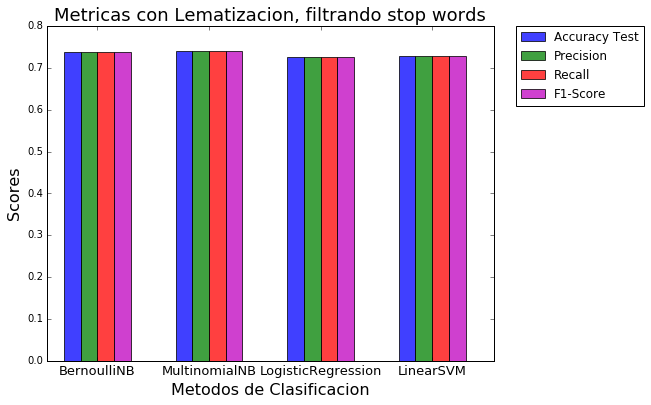

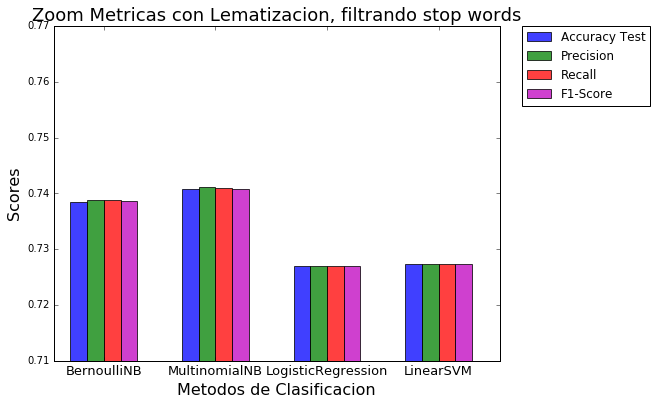

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
#Comparacion de modelos con lematizacion, con filtrado de stop words
n_groups = 4

accuracy_train = [metricas_bernoulliNB[0][0], metricas_multinomial[0][0], metricas_logit[0][0], metricas_svm[0][0]]
accuracy_test = [metricas_bernoulliNB[0][1], metricas_multinomial[0][1], metricas_logit[0][1], metricas_svm[0][1]]
precision = [metricas_bernoulliNB[0][2], metricas_multinomial[0][2], metricas_logit[0][2], metricas_svm[0][2]]
recall = [metricas_bernoulliNB[0][3], metricas_multinomial[0][3], metricas_logit[0][3], metricas_svm[0][3]]
fscore = [metricas_bernoulliNB[0][4], metricas_multinomial[0][4], metricas_logit[0][4], metricas_svm[0][4]]

# create plot
plt.figure(figsize=(8, 6))

index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.75

#rects1 = plt.bar(index, accuracy_train, bar_width, alpha=opacity, color='b', label='Accuracy Train')
rects2 = plt.bar(index + bar_width, accuracy_test, bar_width, alpha=opacity, color='b', label='Accuracy Test')
rects3 = plt.bar(index + 2*bar_width, precision, bar_width, alpha=opacity, color='g', label='Precision')
rects4 = plt.bar(index + 3*bar_width, recall, bar_width, alpha=opacity, color='r', label='Recall')
rects5 = plt.bar(index + 4*bar_width, fscore, bar_width, alpha=opacity, color='m', label='F1-Score')
 
plt.xlabel('Metodos de Clasificacion', fontsize=16)
plt.ylabel('Scores', fontsize=16)
plt.title('Metricas con Lematizacion, filtrando stop words', fontsize=18)
plt.xticks(index + 0.3 + bar_width, ('BernoulliNB', 'MultinomialNB', 'LogisticRegression', 'LinearSVM'), fontsize=13)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

# Zoom para apreciar mejor las diferencias
plt.figure(figsize=(8, 6))
rects2 = plt.bar(index + bar_width, accuracy_test, bar_width, alpha=opacity, color='b', label='Accuracy Test')
rects3 = plt.bar(index + 2*bar_width, precision, bar_width, alpha=opacity, color='g', label='Precision')
rects4 = plt.bar(index + 3*bar_width, recall, bar_width, alpha=opacity, color='r', label='Recall')
rects5 = plt.bar(index + 4*bar_width, fscore, bar_width, alpha=opacity, color='m', label='F1-Score')
 
plt.xlabel('Metodos de Clasificacion', fontsize=16)
plt.ylabel('Scores', fontsize=16)
plt.title('Zoom Metricas con Lematizacion, filtrando stop words', fontsize=18)
plt.xticks(index + 0.3 + bar_width, ('BernoulliNB', 'MultinomialNB', 'LogisticRegression', 'LinearSVM'), fontsize=13)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.ylim(0.71,0.77)
plt.show()

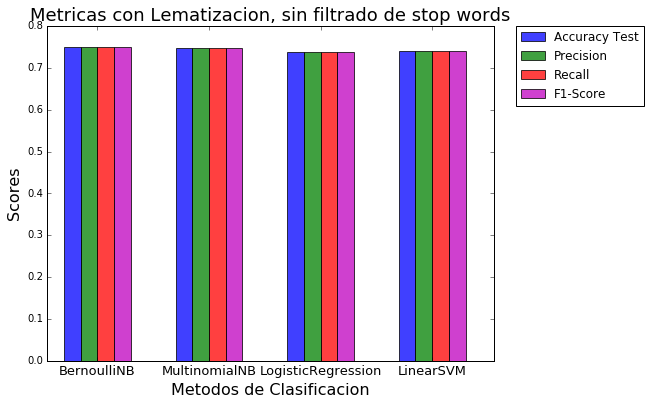

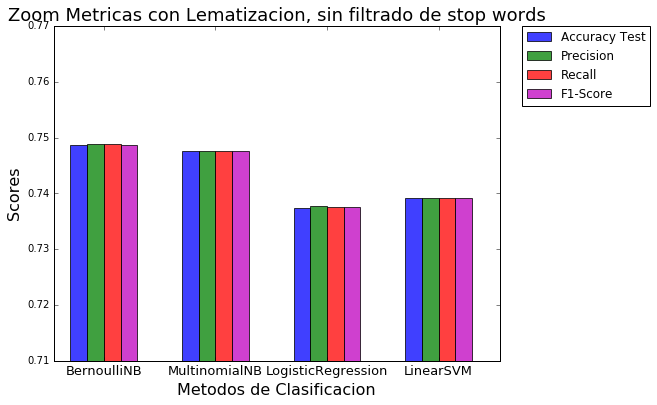

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
#Comparacion de modelos con lematizacion, con filtrado de stop words
n_groups = 4

accuracy_train = [metricas_bernoulliNB[1][0], metricas_multinomial[1][0], metricas_logit[1][0], metricas_svm[1][0]]
accuracy_test = [metricas_bernoulliNB[1][1], metricas_multinomial[1][1], metricas_logit[1][1], metricas_svm[1][1]]
precision = [metricas_bernoulliNB[1][2], metricas_multinomial[1][2], metricas_logit[1][2], metricas_svm[1][2]]
recall = [metricas_bernoulliNB[1][3], metricas_multinomial[1][3], metricas_logit[1][3], metricas_svm[1][3]]
fscore = [metricas_bernoulliNB[1][4], metricas_multinomial[1][4], metricas_logit[1][4], metricas_svm[1][4]]

# create plot
plt.figure(figsize=(8, 6))

index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.75

#rects1 = plt.bar(index, accuracy_train, bar_width, alpha=opacity, color='b', label='Accuracy Train')
rects2 = plt.bar(index + bar_width, accuracy_test, bar_width, alpha=opacity, color='b', label='Accuracy Test')
rects3 = plt.bar(index + 2*bar_width, precision, bar_width, alpha=opacity, color='g', label='Precision')
rects4 = plt.bar(index + 3*bar_width, recall, bar_width, alpha=opacity, color='r', label='Recall')
rects5 = plt.bar(index + 4*bar_width, fscore, bar_width, alpha=opacity, color='m', label='F1-Score')
 
plt.xlabel('Metodos de Clasificacion', fontsize=16)
plt.ylabel('Scores', fontsize=16)
plt.title('Metricas con Lematizacion, sin filtrado de stop words', fontsize=18)
plt.xticks(index + 0.3 + bar_width, ('BernoulliNB', 'MultinomialNB', 'LogisticRegression', 'LinearSVM'), fontsize=13)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

# Zoom para apreciar mejor las diferencias
plt.figure(figsize=(8, 6))
rects2 = plt.bar(index + bar_width, accuracy_test, bar_width, alpha=opacity, color='b', label='Accuracy Test')
rects3 = plt.bar(index + 2*bar_width, precision, bar_width, alpha=opacity, color='g', label='Precision')
rects4 = plt.bar(index + 3*bar_width, recall, bar_width, alpha=opacity, color='r', label='Recall')
rects5 = plt.bar(index + 4*bar_width, fscore, bar_width, alpha=opacity, color='m', label='F1-Score')
 
plt.xlabel('Metodos de Clasificacion', fontsize=16)
plt.ylabel('Scores', fontsize=16)
plt.title('Zoom Metricas con Lematizacion, sin filtrado de stop words', fontsize=18)
plt.xticks(index + 0.3 + bar_width, ('BernoulliNB', 'MultinomialNB', 'LogisticRegression', 'LinearSVM'), fontsize=13)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.ylim(0.71,0.77)
plt.show()

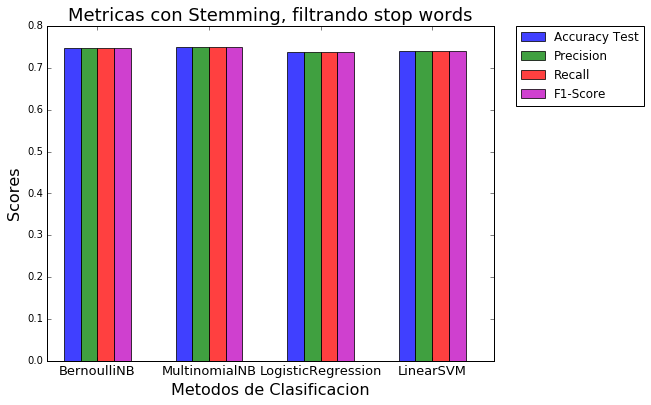

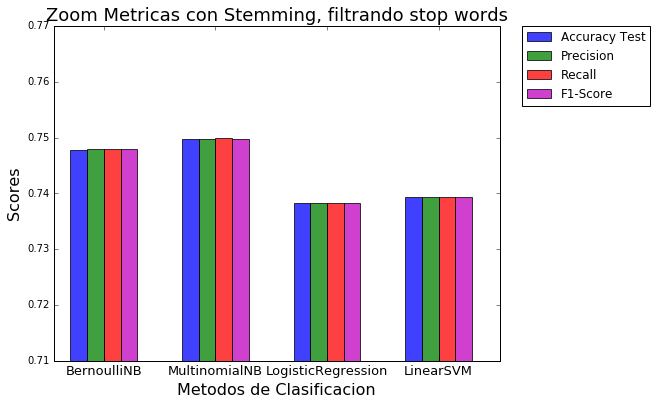

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
#Comparacion de modelos con lematizacion, con filtrado de stop words
n_groups = 4

accuracy_train = [metricas_bernoulliNB[2][0], metricas_multinomial[2][0], metricas_logit[2][0], metricas_svm[2][0]]
accuracy_test = [metricas_bernoulliNB[2][1], metricas_multinomial[2][1], metricas_logit[2][1], metricas_svm[2][1]]
precision = [metricas_bernoulliNB[2][2], metricas_multinomial[2][2], metricas_logit[2][2], metricas_svm[2][2]]
recall = [metricas_bernoulliNB[2][3], metricas_multinomial[2][3], metricas_logit[2][3], metricas_svm[2][3]]
fscore = [metricas_bernoulliNB[2][4], metricas_multinomial[2][4], metricas_logit[2][4], metricas_svm[2][4]]

# create plot
plt.figure(figsize=(8, 6))

index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.75

#rects1 = plt.bar(index, accuracy_train, bar_width, alpha=opacity, color='b', label='Accuracy Train')
rects2 = plt.bar(index + bar_width, accuracy_test, bar_width, alpha=opacity, color='b', label='Accuracy Test')
rects3 = plt.bar(index + 2*bar_width, precision, bar_width, alpha=opacity, color='g', label='Precision')
rects4 = plt.bar(index + 3*bar_width, recall, bar_width, alpha=opacity, color='r', label='Recall')
rects5 = plt.bar(index + 4*bar_width, fscore, bar_width, alpha=opacity, color='m', label='F1-Score')
 
plt.xlabel('Metodos de Clasificacion', fontsize=16)
plt.ylabel('Scores', fontsize=16)
plt.title('Metricas con Stemming, filtrando stop words', fontsize=18)
plt.xticks(index + 0.3 + bar_width, ('BernoulliNB', 'MultinomialNB', 'LogisticRegression', 'LinearSVM'), fontsize=13)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

# Zoom para apreciar mejor las diferencias
plt.figure(figsize=(8, 6))
rects2 = plt.bar(index + bar_width, accuracy_test, bar_width, alpha=opacity, color='b', label='Accuracy Test')
rects3 = plt.bar(index + 2*bar_width, precision, bar_width, alpha=opacity, color='g', label='Precision')
rects4 = plt.bar(index + 3*bar_width, recall, bar_width, alpha=opacity, color='r', label='Recall')
rects5 = plt.bar(index + 4*bar_width, fscore, bar_width, alpha=opacity, color='m', label='F1-Score')
 
plt.xlabel('Metodos de Clasificacion', fontsize=16)
plt.ylabel('Scores', fontsize=16)
plt.title('Zoom Metricas con Stemming, filtrando stop words', fontsize=18)
plt.xticks(index + 0.3 + bar_width, ('BernoulliNB', 'MultinomialNB', 'LogisticRegression', 'LinearSVM'), fontsize=13)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.ylim(0.71,0.77)
plt.show()

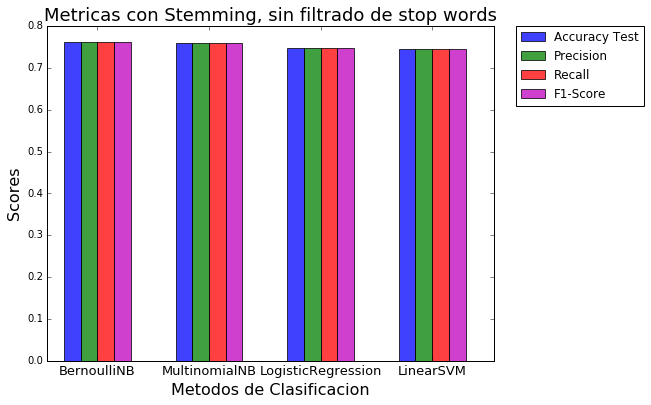

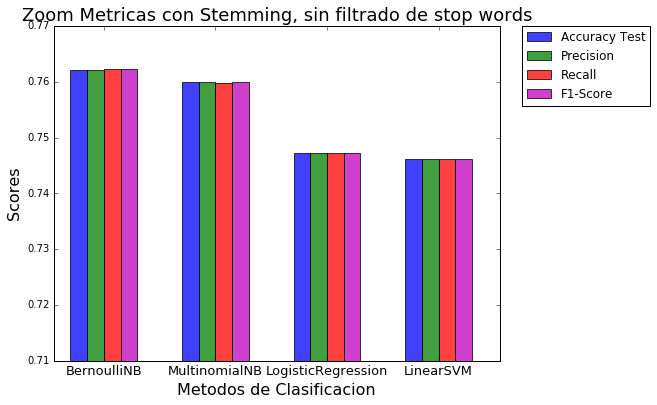

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
#Comparacion de modelos con lematizacion, con filtrado de stop words
n_groups = 4

accuracy_train = [metricas_bernoulliNB[3][0], metricas_multinomial[3][0], metricas_logit[3][0], metricas_svm[3][0]]
accuracy_test = [metricas_bernoulliNB[3][1], metricas_multinomial[3][1], metricas_logit[3][1], metricas_svm[3][1]]
precision = [metricas_bernoulliNB[3][2], metricas_multinomial[3][2], metricas_logit[3][2], metricas_svm[3][2]]
recall = [metricas_bernoulliNB[3][3], metricas_multinomial[3][3], metricas_logit[3][3], metricas_svm[3][3]]
fscore = [metricas_bernoulliNB[3][4], metricas_multinomial[3][4], metricas_logit[3][4], metricas_svm[3][4]]

# create plot
plt.figure(figsize=(8, 6))

index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.75

#rects1 = plt.bar(index, accuracy_train, bar_width, alpha=opacity, color='b', label='Accuracy Train')
rects2 = plt.bar(index + bar_width, accuracy_test, bar_width, alpha=opacity, color='b', label='Accuracy Test')
rects3 = plt.bar(index + 2*bar_width, precision, bar_width, alpha=opacity, color='g', label='Precision')
rects4 = plt.bar(index + 3*bar_width, recall, bar_width, alpha=opacity, color='r', label='Recall')
rects5 = plt.bar(index + 4*bar_width, fscore, bar_width, alpha=opacity, color='m', label='F1-Score')
 
plt.xlabel('Metodos de Clasificacion', fontsize=16)
plt.ylabel('Scores', fontsize=16)
plt.title('Metricas con Stemming, sin filtrado de stop words', fontsize=18)
plt.xticks(index + 0.3 + bar_width, ('BernoulliNB', 'MultinomialNB', 'LogisticRegression', 'LinearSVM'), fontsize=13)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

# Zoom para apreciar mejor las diferencias
plt.figure(figsize=(8, 6))
rects2 = plt.bar(index + bar_width, accuracy_test, bar_width, alpha=opacity, color='b', label='Accuracy Test')
rects3 = plt.bar(index + 2*bar_width, precision, bar_width, alpha=opacity, color='g', label='Precision')
rects4 = plt.bar(index + 3*bar_width, recall, bar_width, alpha=opacity, color='r', label='Recall')
rects5 = plt.bar(index + 4*bar_width, fscore, bar_width, alpha=opacity, color='m', label='F1-Score')
 
plt.xlabel('Metodos de Clasificacion', fontsize=16)
plt.ylabel('Scores', fontsize=16)
plt.title('Zoom Metricas con Stemming, sin filtrado de stop words', fontsize=18)
plt.xticks(index + 0.3 + bar_width, ('BernoulliNB', 'MultinomialNB', 'LogisticRegression', 'LinearSVM'), fontsize=13)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.ylim(0.71,0.77)
plt.show()

A nivel global, se puede ver que en cada gráfico las técnicas se comportan de manera similar. Pero, al realizar un acercamiento se puede notar que los clasificadores Bayesiano ingenuo y multinomial obtienen un mejor desempeño en cada caso (con lematización, con stemming, con y sin filtrado de stop words). Esto refleja que un método más complejo no siempre obtiene mejores resultados. Para este problema un clasificador ingenuo funciona bien debido a que sólo existen dos clases (opinión negativa/positiva). Además se refleja lo ya mencionado anteriormente. Los métodos que utilizan stemming tienen mejores resultados y para textos cuya longitud es pequeña es recomendable no filtrar los stop words debido a que esta información adicional permite una mejor clasificación.